<a href="https://colab.research.google.com/github/suy379/do_it_DL_intro/blob/main/07_%EB%8B%A4%EC%B8%B5_%EC%8B%A0%EA%B2%BD%EB%A7%9D(%EB%8B%A4%EC%A4%91%EB%B6%84%EB%A5%98)%2B%EA%B2%BD%EC%82%AC%ED%95%98%EA%B0%95%EB%B2%95%2C_%EC%BC%80%EB%9D%BC%EC%8A%A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 07-1. 다중 분류 다층 신경망
- 앞서 구현한 DualLayer와 똑같은데, 출력층엔 시그모이드함수가 아니라 __소프트맥스(softmax)__ 함수를 쓴다는 점, 다중분류이기 때문에 출력층의 뉴런이 __클래스 수(c)__와 같다는 점이 다르다.
- 기존에 만든 DualLayer를 조금 수정하여 구현

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class MultiClassNetwork:

    def __init__(self, units=10, batch_size=32, learning_rate=0.1, l1=0, l2=0): #units는 은닉층 뉴런 개수(디폴트:10)
        self.units = units
        self.batch_size = batch_size
        #은닉층의 가중치와 절편
        self.w1 = None
        self.b1 = None
        #출력층의 가중치와 절편
        self.w2 = None
        self.b2 = None
        #은닉층의 활성화 출력값(출력층에 입력되는 A1)
        self.a1 = None
        #기록 
        self.losses = [] #train_loss
        self.val_losses = [] #val_loss
        self.lr = learning_rate
        self.l1 = l1
        self.l2 = l2

    #정방향 계산 1: forpass
    def forpass(self, x):
        z1 = np.dot(x, self.w1) + self.b1 
        self.a1 = self.sigmoid(z1) #in 은닉층 
        z2 = np.dot(self.a1, self.w2) + self.b2
        return z2 #z2는 뒤의 fit 메서드에서 softmax함수로 적용되어 A2 출력됨.

    #정방향 계산 2: sigmoid, softmax --> a를 출력
    def sigmoid(self, z): #은닉층에 적용 
        a = 1 / (1+np.exp(-z))
        return a

    def softmax(self, z): #출력층에 적용 
        exp_z = np.exp(z) 
        return exp_z / np.sum(exp_z, axis=1).reshape(-1,1) #열방향 연산이므로 각 행의 합 출력. np.sum한 값을 열벡터로 만들어야 exp_z와 연산가능 

    #역방향 계산: backprop
    def backprop(self, x, err):
        m = len(x) #평균 그레디언트를 계산해야 해서 m으로 나눠줘야 한다(왜냐면 배치 경사하강법이기 때문!)
        w2_grad = np.dot(self.a1.T, err) / m
        b2_grad = np.sum(err) / m
        #err_to_hidden 만들기(err는 fit 메서드에서 만들어져 있다고 생각)
        err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1-self.a1) #원소별 곱은 * 기호 
        w1_grad = np.dot(x.T, err_to_hidden) / m
        b1_grad = np.sum(err_to_hidden, axis=0) / m #b1은 1x10(뉴런수)여서 한행을 모두 더해야함.
        return w1_grad, b1_grad, w2_grad, b2_grad 


    ### 중요한 학습 메서드 3개 수정(init_weights, fit, training) ###
    def init_weights(self, n_features, n_classes): 
        np.random.seed(42) #실습 결과와 동일하게 하기 위함(실전에선 필요x)
        self.w1 = np.random.normal(0,1,(n_features, self.units)) #(30x10)
        self.b1 = np.zeros(self.units) #스칼라 10개 
        self.w2 = np.random.normal(0,1,(self.units, n_classes)) #(10xc) 출력뉴런은 클래스의 개수 c
        self.b2 = np.zeros(n_classes)  #스칼라 c개 

    ##for epoch 수행하면서 A2계산, loss 계산 
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        self.init_weights(x.shape[1], y.shape[1]) #n_features, n_classes 값 대입(여기서 y는 원-핫 인코딩된 값이므로 열의 수가 클래스 개수 c가 된다.) 
        np.random.seed(42) #실습결과와 동일함을 위해(실전에선 x)
        #epoch만큼 반복
        for i in range(epochs):
            loss = 0
            print('.', end='')#편의상 훈련 진행상황을 살펴보기 위해 출력 
            for x_batch, y_batch in self.gen_batch(x,y): #뒤의 gen_batch 메서드에서 배치사이즈만큼의 x_batch, y_batch 꺼냄 
                a = self.training(x_batch, y_batch) #뒤의 training 메서드에서 수행(출력값: A2)
                #loss 계산(평균 loss로 반환)
                a = np.clip(a, 1e-10, 1-1e-10)
                loss += np.sum(-y_batch*np.log(a)) #확률적 경사하강법처럼 loss를 다 더하다가 for문 벗어나면 평균값 구해서 추가 
            self.losses.append((loss+self.reg_loss())/len(x)) #전체 샘플 수로 나눠 평균 loss 구함(train loss)
            self.update_val_loss(x_val, y_val) #val loss 

    ##정방향 계산, err 계산, 오차 역전파(가중치 업데이트) 수행 
    def training(self, x, y):
        m = len(x)
        z = self.forpass(x) #z2 반환
        a = self.softmax(z) #출력층의 A2 반환 => loss 계산 가능!
        err = -(y-a)
        #그레디언트 값 계산
        w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
        #규제가 적용된 경우, 가중치의 그레디언트 값 더해줌.(반드시 그레디언트의 평균값 반환)
        w1_grad += (self.l1*np.sign(self.w1) + self.l2*self.w1) / m
        w2_grad += (self.l1*np.sign(self.w2) + self.l2*self.w2) / m
        #가중치, 절편 업데이트(학습률도 곱해줘야 한다!)
        self.w1 -= w1_grad*self.lr
        self.b1 -= b1_grad*self.lr
        self.w2 -= w2_grad*self.lr
        self.b2 -= b2_grad*self.lr 
        return a #A2 출력 

    ## get_batch 메서드--> x,y가 들어오면 랜덤하게 batch_size만큼 x_batch, y_batch 뽑아 출력
    def gen_batch(self, x, y):
        length = len(x)
        bins = length // self.batch_size #미니배치의 횟수 
        if length % self.batch_size: #나머지가 있다면 횟수 +1 
            bins +=1 
        #인덱스 랜덤 섞기
        indexes = np.random.permutation(np.arange(len(x)))
        x = x[indexes]
        y = y[indexes]
        #미니배치 횟수만큼 실행 
        for i in range(bins):
            #인덱스 설정하여 나눠줌 
            start = self.batch_size*i
            end = self.batch_size*(i+1)
            yield x[start:end], y[start:end] #x_batch, y_batch 반환. (return으로 해도 되는데 메모리 사용이 효율적인 제너레이터로 접근함.)

    ### 검증셋의 손실(val_loss)를 구하는 메서드 
    def update_val_loss(self, x_val, y_val):
        if x_val is None: 
            return
        #train set에서와 동일하게 접근해가면 됨.
        z = self.forpass(x_val)
        a = self.softmax(z) #A2 출력 
        #loss값 계산
        a = np.clip(a, 1e-10, 1-1e-10)
        val_loss = np.sum(-y_val*np.log(a))
        #val_loss 평균값 반환 
        self.val_losses.append((val_loss + self.reg_loss())/len(y_val))

    ### 규제에 대한 메서드 
    def reg_loss(self):
        return self.l1*(np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2)))  + self.l2 / 2 *(np.sum(self.w1**2) + np.sum(self.w2**2))
        
    ### 예측 & 평가 메서드 수정
    #예측 메서드--> 이 안에는 x_val만 넣는다.
    def predict(self, x):
        z = self.forpass(x) #Z2 반환 
        return np.argmax(z, axis=1) #Z2의 각 행에서 가장 큰 값의 인덱스 반환-> 클래스 예측한 값과 동일! 
    
    # 평가 메서드-- 이 안에는 앞서 predict로 반환된 값과 y_val를 비교한 정확도를 출력.
    def score(self, x, y):
        return np.mean(self.predict(x) == np.argmax(y, axis=1)) 


### 패션 MNIST 데이터를 이용하여 의류 이미지 분류하기(다중 분류)
- 앞서 구현한 MultiClassNetwork 클래스로 모델을 구현한다.

In [ ]:
#코랩에 텐서플로우 최신 버전 설치 
!pip install tensorflow_gpu==2.0.0

In [ ]:
#데이터 준비하기 
import tensorflow as tf
print(tf.__version__)

2.0.0


In [ ]:
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
#shape 확인하기
print(x_train_all.shape, y_train_all.shape)

(60000, 28, 28) (60000,)


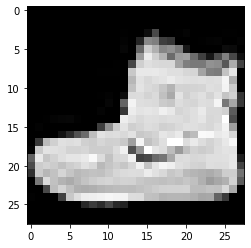

In [ ]:
#x_train_all은 개수x높이x너비를 가진 3차원 배열. 샘플을 하나 뽑아 이미지를 확인해보자.
plt.imshow(x_train_all[0], cmap='gray')
plt.show()

In [ ]:
#타깃의 내용과 의미 확인하기
print(y_train_all[:10]) #타깃은 0~9까지의 정수로 이루어진 클래스 레이블이 들어있음.

[9 0 0 3 0 2 7 2 5 5]


In [ ]:
class_names = ['티셔츠/윗도리', '바지', '스웨터', '드레스', '코트', '샌들', '셔츠', '스니커즈', '가방', '앵클부츠'] #레이블 0~9에 대응.
print(class_names[y_train_all[0]])

앵클부츠


In [ ]:
#타깃 분포 확인
#총 개수는 6만개이고, 각 레이블에 해당하는 것이 6000개씩 있음.(클래스 값이 아주 고르게 분포됨)
np.bincount(y_train_all)

array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

In [ ]:
#train, val set 나누기
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

#타겟의 레이블 분포가 완전 고르게 잘 나뉨 
print(np.bincount(y_train)) #train set
print(np.bincount(y_val)) #val set 

[4800 4800 4800 4800 4800 4800 4800 4800 4800 4800]
[1200 1200 1200 1200 1200 1200 1200 1200 1200 1200]


In [ ]:
#입력 데이터 정규화 (피처값 X를 표준화)
## 앞서 cancer 데이터는 표준화로 평균0, 분산1에 맞춰주었는데
## 이러한 이미지 데이터는 픽셀 하나당 0~255 사이의 값을 가지므로 이 값을 255로 나누면 0~1 사이의 값이 된다.
print(x_val[290:300])
x_train = x_train/255
x_val = x_val/255
print(x_val[290:300])

[[[  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  ...
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]]

 [[  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  ...
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]]

 [[  0   0   1 ...   0   0   0]
  [  0   0   0 ...   1   0   0]
  [  0   0   1 ...   0   1   0]
  ...
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]]

 ...

 [[  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  ...
  [  0  51  48 ...  51  59   0]
  [  0  77  59 ...  59  62   0]
  [  0  77  55 ...  48  44   0]]

 [[  0   0   0 ...   0   0   0]
  [  0   1   0 ...   0   0   0]
  [  0   2   0 ...  91   0   0]
  ...
  [  1   1   0 ... 102   0   1]
  [  0   0   3 ...  34   0   2]
  [  0   0   0 ...   0   0  

In [ ]:
#하지만 문제가 있다!!
#바로 피처(X데이터)가 3차원이라는 것. 우리가 구현한 클래스는 2차원 배열만 넣을 수 있는데..!
#x_train의 경우 48000개의 데이터, 가로 세로 28x28개이므로 28x28 이 부분을 하나로 만들어서(28x28=784로) 2차원으로 변경하자.
print(x_train.shape, x_val.shape)
print(28*28)

(48000, 28, 28) (12000, 28, 28)
784


In [ ]:
#피처 데이터의 열을 784로 변경
x_train = x_train.reshape(-1, 784)
x_val = x_val.reshape(-1, 784)

In [ ]:
print(x_train.shape, x_val.shape) #2차원으로 잘 변경되었다.

(48000, 784) (12000, 784)


In [ ]:
#텐서플로우에서 원-핫인코딩 구현하기 - to_categorical 이용(문자열은 안됨. 숫자만 가능)
#예시
tf.keras.utils.to_categorical([0,1,3])

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [ ]:
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)
print(y_train_encoded.shape, y_val_encoded.shape)

(48000, 10) (12000, 10)


In [ ]:
#잘 되었는지 확인
print(y_train[0])
print(y_train_encoded[0]) #정수 레이블 6이 원-핫인코딩 되었다.

6
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


- 이제 전처리된 __x_train, y_train_encoded__로 학습을 진행하고,
- 전처리된 __x_val, y_val_encoded__로 평가를 진행한다.
- 앞서 만든 클래스에 적용!

In [ ]:
#객체
fc = MultiClassNetwork(units=100, batch_size=256) #은닉층 뉴런수 100개, 규제 적용x
#학습
fc.fit(x_train, y_train_encoded, x_val = x_val, y_val = y_val_encoded, epochs=100) #데이터가 몇만개 단위이므로 배치사이즈를 크게하더라도 학습이 진행되는 횟수가 많다.
                                                                                                                        #(또한 뉴런수도 너무 많아서 가중치 수가 많으니까&배치사이즈 크니까  속도 느림)

....................................................................................................

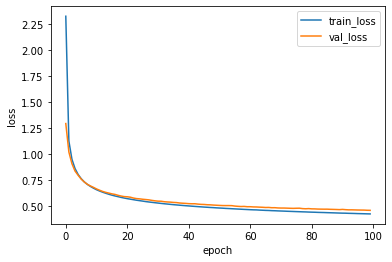

In [ ]:
#train_loss vs. val_loss
plt.plot(fc.losses)
plt.plot(fc.val_losses)

plt.legend(['train_loss','val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
#평가
fc.score(x_val, y_val_encoded)

0.8375

## 07-2. Tensorflow & Keras 이용하여 신경망 만들기
- 직접 다층 신경망을 구현하였지만 성능이 크게 좋지 않음. 더 높은 성능을 기대하려면 전문적인 인공신경망 라이브러리를 사용해야 함.
- 여기서 사용할 것은 __구글의 텐서플로__를 이용한 인공신경망이며, 텐서플로 내의 __케라스 API__를 이용할 것이다.

In [ ]:
## 케라스에 대해 알아보자.
# 케라스는 딥러닝 패키지인 텐서플로를 직접 구현하려면 많은 코드를 입력해야 되는 것을 간단하게 구현하게 해줌. (밑은 예시, 실행x)

#신경망 모델 만듦
model = tf.keras.models.Sequential()
#완전 연결층 추가
model.add(tf.keras.layers.Dense(1))
#옵티마이저, 손실함수 지정
model.compile(optimizer='sgd', loss='mse')
#훈련데이터 사용하여 에포크 횟수만큼 훈련
model.fit(x_train, y_train, epochs=10)

### 케라스의 Sequential 클래스 사용하기
- 우리가 만드려는 것은 `완전 연결 신경망`이므로, Sequential과 Dense 클래스를 함께 사용한다.
- Sequential 객체 생성 시 층 추가하기 or 객체 생성 후 add() 메서드를 사용해 층 추가하기

In [ ]:
#1) Sequential 객체 생성 시 층 추가하기
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
model = Sequential([Dense(...), ..., ...]) #파이썬 리스트로 층을 추가할 것.

In [ ]:
#2) add() 메서드 사용해 층 추가하기
dense = Dense(...)
model.add(dense)

In [ ]:
#만드려고 하는 층이 많은 경우 한줄로 쓰기
model = Sequential()
model.add(Dense(...))
model.add(Dense(...))

### Dense 클래스 사용하기
- Dense 내의 매개변수: unit(은닉층 내의 뉴런 수, 하이퍼파라미터), activation(활성화 함수, 디폴트는 None, sigmoid/softmax/tanh/relu 등 다양하게 적용), kernel_initializer(가중치 규제)

In [ ]:
#예를들어 은닉층
Dense(unit=100, activation='sigmoid') 

### 모델 최적화 알고리즘, 손실 함수 설정
- 모델을 훈련하기 위해 꼭 지정해야 함.
- 다중 분류의 최적화 알고리즘(optimizer): 경사하강법(sgd), 손실함수(loss): 크로스-엔트로피 손실함수.
- _손실 함수의 경우, 회귀-제곱오차면 loss='mse', 로지스틱 손실함수면 loss='binary_crossentropy', 다중분류면 loss='categorical_crossentropy'_

In [ ]:
model.compile(optimizer='sgd', loss='categorical_crossentropy')

### 모델 훈련, 예측, 평가 메서드
- 똑같은 이름으로 fit, predict, evaluate이다.

In [ ]:
#전형적인 Sequentail 클래스 사용법(실행x)
model = Sequential()
model.add(Dense(...))
model.add(Dense(...))
model.compile(optimizer='', loss='')
model.fit(x_train, y_train, epochs='')
model.predict(x_val)
model.evaluate(x_val, y_val)

## 케라스로 다중 분류 신경망 만들기(여기서부터 실행)
- 케라스로 다중분류 신경망을 만든 후
- 패션 MNIST 데이터를 넣어 모델을 훈련하자.

In [ ]:
#모델 생성하기
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()

In [ ]:
#은닉층, 출력층 추가하기
model.add(Dense(units=100, activation='sigmoid', input_shape=(784,))) ##중요: 첫번째 은닉층은 input_shape으로 입력 데이터의 크기(피처 수)를 지정해야 함. 샘플 수(m)는 이미 있으므로 입력할 필요x
                                                                                                            #여기선 은닉층이 1개라서 은닉층에 이를 입력해야 하지만, 만일 은닉층이 여러개라면 첫번째 은닉층에만 써주면 됨.
model.add(Dense(units=10, activation='softmax')) #출력층 

In [ ]:
#최적화 알고리즘, 손실함수 지정하기
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy']) #이따 fit에서 모델 훈련하면서 정보 기록할 때 loss뿐 아니라 accuracy도 기록하기 위해 설정 

In [ ]:
#모델 훈련하기--> fit을 수행하면서 train set을 훈련시킬 뿐(가중치 업데이트) 아니라 train_loss를 저장한다. (또한 앞에서 metrics를 지정했으므로 accuracy도 저장돼있음.)
                        #역서 우리가 val_loss도 저장하고 싶으면 validation_data에 val_set을 지정해주어야 한다!!
history = model.fit(x_train, y_train_encoded, epochs=40,
                    validation_data=(x_val, y_val_encoded))

Train on 48000 samples, validate on 12000 samples
Epoch 1/40
48000/48000 [==============================] - 6s 126us/sample - loss: 1.3986 - accuracy: 0.6314 - val_loss: 0.9827 - val_accuracy: 0.7188
Epoch 2/40
48000/48000 [==============================] - 5s 95us/sample - loss: 0.8568 - accuracy: 0.7367 - val_loss: 0.7630 - val_accuracy: 0.7549
Epoch 3/40
48000/48000 [==============================] - 5s 100us/sample - loss: 0.7197 - accuracy: 0.7615 - val_loss: 0.6723 - val_accuracy: 0.7734
Epoch 4/40
48000/48000 [==============================] - 5s 99us/sample - loss: 0.6520 - accuracy: 0.7777 - val_loss: 0.6176 - val_accuracy: 0.7913
Epoch 5/40
48000/48000 [==============================] - 5s 101us/sample - loss: 0.6085 - accuracy: 0.7912 - val_loss: 0.5813 - val_accuracy: 0.8022
Epoch 6/40
48000/48000 [==============================] - 5s 99us/sample - loss: 0.5774 - accuracy: 0.8009 - val_loss: 0.5548 - val_accuracy: 0.8075
Epoch 7/40
48000/48000 [=============================

In [ ]:
#history 객체에 담겨있는 값이 무엇이 있는지 알아보자.
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [ ]:
print(history.history)

{'loss': [1.3986043086449305, 0.8567952765822411, 0.7196891803344091, 0.6519589006900788, 0.6084530092676481, 0.5773734916349252, 0.5533709281980992, 0.5349730493426323, 0.5197173791329066, 0.5071387529869874, 0.49673707328240074, 0.4875668819844723, 0.4794711616237958, 0.4724587612748146, 0.46603262547651925, 0.46005425560474394, 0.4547547954718272, 0.4499749283492565, 0.4452951168715954, 0.441247707799077, 0.43698050288359325, 0.4334572148124377, 0.42990910650293035, 0.42677171382308005, 0.4235111889044444, 0.4203830238083998, 0.41757026289900145, 0.41482454164822896, 0.41213515238960585, 0.4096104492644469, 0.4073757450679938, 0.4045799449831247, 0.40270341858267783, 0.4007394690513611, 0.3985877780367931, 0.39641342549026015, 0.3944866904417674, 0.39270282932122547, 0.3906563422481219, 0.3888843545218309], 'accuracy': [0.6314167, 0.7366667, 0.7615, 0.77770835, 0.7912083, 0.8008958, 0.81016666, 0.8157708, 0.8196875, 0.82458335, 0.827625, 0.8304167, 0.8333333, 0.836, 0.83677083, 0.83

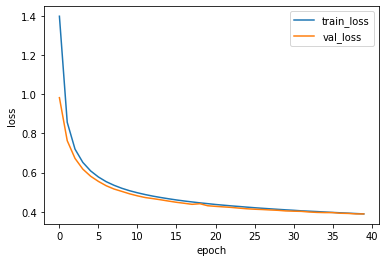

In [ ]:
# history 내의 train_loss vs. val_loss 비교
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.legend(['train_loss','val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

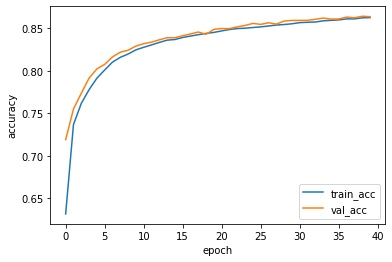

In [ ]:
# history 내의 train_acc vs. val_acc 비교
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.legend(['train_acc', 'val_acc'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [ ]:
#마지막으로, 성능 계산
model.evaluate(x_val, y_val_encoded)

12000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.38879197522004444, 0.86366665]

In [ ]:
loss, accuracy = model.evaluate(x_val, y_val_encoded, verbose=0)
print(loss)
print(accuracy)

0.38879197522004444
0.86366665


- 최종 성능은 약 86%로, 직접 클래스로 구현했던 것과 조금 더 높게 나왔다.
- 케라스로 구현했을 때 성능이 확 좋게 나오지 않은 것은 우리가 하이퍼파라미터를 그대로 쓴것도 있고(실전에선 하이퍼 파라미터도 튜닝해야 한다. units(뉴런 수), 층의 개수, fit에서 epochs, batch_size 등.) 더 확실한 이유는 *케라스의 성능이 낮아서가 아니라 케라스가 이미지 데이터에 잘 맞는 모델이 아니기 때문*이다.
- 다음 8장에선 이미지 분류에 효과적은 __합성곱 신경망(convolution NN)__에 대해 알아본다.(마찬가지로 직접 구현해보고, 케라스로 적용)
